In [314]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
from tqdm import tqdm
from algorithms.Model_LightGBM import LGBM_Generator
from preprocessing.preprocessing import preprocessing
from metrics.MAPE import MAPE

from utils import add_all_features, dfs_gen

train = pd.read_csv("../dataset/original/train.csv")
test = pd.read_csv("../dataset/original/x_test.csv")

useTest = True
useScope = True
isEvaluation = False
useSampleWeights, weights_type = True, 0

if isEvaluation:
    useTest = False
    useScope = False
#   --------------- Preprocessing -----------------

df = preprocessing(train, test, useTest=useTest)

#   --------------- Features -----------------

df, categorical_f = add_all_features(df)
categorical_f = ['sku', 'pack', 'brand'] + categorical_f

df = df.sort_values('Date')
#   --------------- Model -----------------

6019it [00:01, 5891.34it/s]
6019it [00:00, 32585.88it/s]
100%|██████████| 43/43 [00:00<00:00, 648.08it/s]


In [315]:
def huber_approx_obj(y_true, y_pred):
    d = y_pred - y_true #remove .get_labels() for sklearn
    h = 3  #h is delta in the graphic
    scale = 1 + (d / h) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

def wmape_train_(y_true, data):
    """
    IMPORTANTE: sortare prima gli elementi del df per ('sku', 'Date'): df.sort_values(['sku','Date']

    Give less importance to previous [in time] values, exponentially
    :param y_true:
    :param y_pred:
    :return:
    """
    # global s
    y_true = np.array(y_true)
    y_pred = data.get_label()

    N = int(y_true.shape[0] / 133)
    weight = np.arange(y_true.shape[0])
    weight = weight % N
    weight = weight / N
    grad = -100 * ((y_true - y_pred) / y_true) * (np.exp(weight))
    hess = 100 / (y_true) * (np.exp(weight))
    return grad, hess

In [316]:
import xgboost as xgb

In [317]:
prediction_df = pd.DataFrame()

sample_weights = None
#xgb_model = XGBRegressor()

In [318]:
dummy = pd.get_dummies(df.cluster, prefix='cluster')
df[dummy.columns] = dummy

In [319]:
cat_cols = ['pack', 'brand', 'scope', 'heavy_light', 'cluster']
df = df.drop(cat_cols, axis=1)

In [320]:
if useTest:
    df = df.sort_values('Date')
    test_dates = df[df.Date >= '2019-06-29']
    test_dates = test_dates.drop_duplicates('Date').Date
    gen = dfs_gen(df, test_dates)
else:
    train = df[~df.target.isna()]
    _, _, val_dates = train_validation_split(train)
    gen = dfs_gen(train, val_dates)

In [321]:
params = {
    'obj':wmape_train_,
    'learning_rate': 0.05,
    'max_depth': 8,
    'min_child_weight': 3,
    'tree_method': 'hist'
}

In [322]:
# Per far funzionare l'incremental learning, il primo modello che viene fatto partire deve essere un classico xgboost
# con un certo numero di num_boost_rounds. I modelli successivi invece devono fare solo l'update del modello, 
# non devono creare nuovi alberi, dunque 'updater' viene impostato a 'refresh' e il 'process_type' = 'update'

prev_df_test = pd.DataFrame()
drop_target = ['real_target', 'target', 'Date', 'sku']
xgb_model = None
for i, (df_train, df_test) in enumerate(gen):
        
    if i == 0:
        xgb_model = xgb.train(params, dtrain=xgb.DMatrix(df_train.drop(drop_target, axis=1), df_train.target),
                             num_boost_round=400)
    else:
        #xgb_model.fit(prev_df_test.drop(drop_target, axis=1), prev_df_test.target, xgb_model='xgb_model_online.model')
        params.update({
            #'learning_rate': 0.1,
            'updater':'refresh',
            'process_type': 'update',
            'refresh_leaf': True,
            #'reg_lambda': 3,  # L2
            'reg_alpha': 3,  # L1
            'silent': False,
        })
        
        xgb_model = xgb.train(params, dtrain=xgb.DMatrix(df_train.drop(drop_target, axis=1), df_train.target), 
                              num_boost_round=400,
                              xgb_model=xgb_model)
    
    df_test['prediction'] = xgb_model.predict(xgb.DMatrix(df_test.drop(drop_target, axis=1)))
    print(df_test[['Date', 'sku', 'target', 'prediction']])
    
    #xgb_model.save_model('xgb_model_online.model')
    prediction_df = pd.concat([prediction_df, df_test[['Date', 'sku', 'real_target', 'target', 'prediction']]])

    prev_df_test = df_test.drop(['prediction'], axis=1).copy()
    

[16:44:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
133  2019-06-29   144   9.694555    9.642632
291  2019-06-29   546  11.025295   11.083312
449  2019-06-29   549  10.427565   10.684768
607  2019-06-29   554  11.717286   11.888983
765  2019-06-29   686   9.960718    9.915442
923  2019-06-29   688  10.465415   10.511697
1081 2019-06-29  1027  10.819638   11.052897
1239 2019-06-29  1035  10.458636   10.545299
1397 2019-06-29  1051   9.349145    9.151847
1555 2019-06-29  1058  10.364450   10.427039
1713 2019-06-29  1065  11.352592   11.485950
1871 2019-06-29  1206  10.659375   10.685504
[16:44:56] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:44:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
134  2019-07-06   144   9.804496    9.573836
292  2019-07-06   546  11.210563   11.053087
450  2019-07-06   549  10.615039   10.449719
608  2019-07-06   554  11.803047   11.813383
766  2019-07-06   686  10.143292    9.778932
924  2019-07-06   688  10.527794   10.499174
1082 2019-07-06  1027  10.969284   10.869514
1240 2019-07-06  1035  10.636696   10.545434
1398 2019-07-06  1051   9.593832    9.176856
1556 2019-07-06  1058  10.434616   10.399614
1714 2019-07-06  1065  11.432778   11.400132
1872 2019-07-06  1206  10.746777   10.637119
[16:44:56] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:44:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
135  2019-07-13   144   9.838896    9.776195
293  2019-07-13   546  11.691381   11.333339
451  2019-07-13   549  11.257414   10.760057
609  2019-07-13   554  12.250123   11.954176
767  2019-07-13   686  10.218298   10.045627
925  2019-07-13   688  10.887848   10.623585
1083 2019-07-13  1027  11.417614   11.136806
1241 2019-07-13  1035  11.204006   10.706015
1399 2019-07-13  1051   9.658226    9.110617
1557 2019-07-13  1058  10.939231   10.720225
1715 2019-07-13  1065  11.927284   11.469122
1873 2019-07-13  1206  11.220016   10.945245
[16:44:57] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:44:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
136  2019-07-20   144   9.788862    9.576155
294  2019-07-20   546  11.879996   11.620704
452  2019-07-20   549  11.474018   11.110146
610  2019-07-20   554  12.392320   12.312264
768  2019-07-20   686  10.179527   10.198300
926  2019-07-20   688  11.188967   10.935894
1084 2019-07-20  1027  11.598718   11.390972
1242 2019-07-20  1035  11.415180   11.615912
1400 2019-07-20  1051   9.640303    9.259352
1558 2019-07-20  1058  11.096546   11.258169
1716 2019-07-20  1065  12.045135   11.815891
1874 2019-07-20  1206  11.369817   11.151166
[16:44:57] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:44:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
137  2019-07-27   144   9.747185    9.833300
295  2019-07-27   546  11.790550   11.406244
453  2019-07-27   549  11.411247   11.168259
611  2019-07-27   554  12.319879   11.864416
769  2019-07-27   686  10.114194    9.853769
927  2019-07-27   688  11.088155   11.049820
1085 2019-07-27  1027  11.489442   11.393739
1243 2019-07-27  1035  11.359914   11.162217
1401 2019-07-27  1051   9.571157    9.654127
1559 2019-07-27  1058  11.002983   10.986220
1717 2019-07-27  1065  11.924134   11.671117
1875 2019-07-27  1206  11.266808   11.064225
[16:44:58] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:44:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
138  2019-08-03   144  10.659469   10.734159
296  2019-08-03   546  11.389243   11.304700
454  2019-08-03   549  10.920311   10.958814
612  2019-08-03   554  11.959596   11.837931
770  2019-08-03   686  11.067544   10.753189
928  2019-08-03   688  10.656883   10.691104
1086 2019-08-03  1027  11.063148   11.148506
1244 2019-08-03  1035  10.919298   10.909468
1402 2019-08-03  1051  10.369012   10.286742
1560 2019-08-03  1058  10.529239   10.719683
1718 2019-08-03  1065  11.564540   11.275690
1876 2019-08-03  1206  10.843319   10.856318
[16:44:58] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:44:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
139  2019-08-10   144  11.075226   11.031512
297  2019-08-10   546  10.926154   11.039357
455  2019-08-10   549  10.345285   10.325840
613  2019-08-10   554  11.624574   11.582247
771  2019-08-10   686  11.340891   11.045416
929  2019-08-10   688  10.348494   10.459870
1087 2019-08-10  1027  10.646638   10.753212
1245 2019-08-10  1035  10.431347   10.353621
1403 2019-08-10  1051  10.763779   10.693086
1561 2019-08-10  1058  10.146434   10.286555
1719 2019-08-10  1065  11.258859   11.173940
1877 2019-08-10  1206  10.519862   10.543958
[16:44:59] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:44:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
140  2019-08-17   144  11.061422   11.107522
298  2019-08-17   546  10.917504   10.883150
456  2019-08-17   549  10.296104   10.299753
614  2019-08-17   554  11.600286   11.794367
772  2019-08-17   686  11.275772   11.348157
930  2019-08-17   688  10.323151   10.331116
1088 2019-08-17  1027  10.631833   10.696096
1246 2019-08-17  1035  10.432202   10.326009
1404 2019-08-17  1051  10.774760   10.826463
1562 2019-08-17  1058  10.170686   10.072005
1720 2019-08-17  1065  11.268060   11.240436
1878 2019-08-17  1206  10.543735   10.428009
[16:45:00] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:45:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
141  2019-08-24   144  10.528570   10.527312
299  2019-08-24   546  11.004863   10.977816
457  2019-08-24   549  10.385265   10.260360
615  2019-08-24   554  11.669938   11.592492
773  2019-08-24   686  10.715795   10.655437
931  2019-08-24   688  10.377296   10.416170
1089 2019-08-24  1027  10.698695   10.733601
1247 2019-08-24  1035  10.493106   10.367570
1405 2019-08-24  1051  10.181612   10.256743
1563 2019-08-24  1058  10.238459   10.149879
1721 2019-08-24  1065  11.328233   11.248149
1879 2019-08-24  1206  10.586003   10.504907
[16:45:00] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:45:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
142  2019-08-31   144   9.906932    9.769867
300  2019-08-31   546  11.085889   11.019916
458  2019-08-31   549  10.473958   10.457780
616  2019-08-31   554  11.744838   11.767038
774  2019-08-31   686  10.123145    9.772430
932  2019-08-31   688  10.448338   10.356389
1090 2019-08-31  1027  10.792037   10.609584
1248 2019-08-31  1035  10.576815   10.437140
1406 2019-08-31  1051   9.589462    9.361090
1564 2019-08-31  1058  10.298431   10.143454
1722 2019-08-31  1065  11.407709   11.286900
1880 2019-08-31  1206  10.666091   10.633705
[16:45:01] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:45:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
143  2019-09-07   144   9.973107    9.725812
301  2019-09-07   546  11.143267   11.219057
459  2019-09-07   549  10.577197   10.586109
617  2019-09-07   554  11.822225   11.812047
775  2019-09-07   686  10.179337   10.214498
933  2019-09-07   688  10.491246   10.485342
1091 2019-09-07  1027  10.884854   10.864565
1249 2019-09-07  1035  10.656577   10.642433
1407 2019-09-07  1051   9.632466    9.580860
1565 2019-09-07  1058  10.354117   10.351370
1723 2019-09-07  1065  11.427346   11.454090
1881 2019-09-07  1206  10.727334   10.757176
[16:45:01] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:45:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
144  2019-09-14   144   9.893336    9.808900
302  2019-09-14   546  11.587281   11.413294
460  2019-09-14   549  11.152888   10.816149
618  2019-09-14   554  12.171155   11.973055
776  2019-09-14   686  10.105530   10.008737
934  2019-09-14   688  10.956353   10.681906
1092 2019-09-14  1027  11.345382   11.052251
1250 2019-09-14  1035  11.163992   10.898667
1408 2019-09-14  1051   9.576926    9.654851
1566 2019-09-14  1058  10.869140   10.558663
1724 2019-09-14  1065  11.832767   11.474010
1882 2019-09-14  1206  11.154349   10.972388
[16:45:02] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:45:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
145  2019-09-21   144   9.839482    9.812474
303  2019-09-21   546  11.843667   11.582373
461  2019-09-21   549  11.419032   11.148723
619  2019-09-21   554  12.396375   12.136210
777  2019-09-21   686  10.106265   10.044828
935  2019-09-21   688  11.185698   10.896049
1093 2019-09-21  1027  11.581472   11.276993
1251 2019-09-21  1035  11.410638   11.213501
1409 2019-09-21  1051   9.590488    9.621415
1567 2019-09-21  1058  11.090507   10.818020
1725 2019-09-21  1065  12.049641   11.781273
1883 2019-09-21  1206  11.327547   11.074915
[16:45:02] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:45:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
146  2019-09-28   144   9.815530    9.845394
304  2019-09-28   546  11.809572   11.610323
462  2019-09-28   549  11.390181   11.311554
620  2019-09-28   554  12.402001   12.022999
778  2019-09-28   686  10.121216   10.046800
936  2019-09-28   688  11.157564   11.172516
1094 2019-09-28  1027  11.539051   11.395678
1252 2019-09-28  1035  11.359238   11.263263
1410 2019-09-28  1051   9.588571    9.639307
1568 2019-09-28  1058  11.061610   10.959662
1726 2019-09-28  1065  12.030552   11.798582
1884 2019-09-28  1206  11.294521   11.153697
[16:45:02] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:45:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
147  2019-10-05   144  10.621279   10.724493
305  2019-10-05   546  11.410184   11.494132
463  2019-10-05   549  10.889752   10.972155
621  2019-10-05   554  12.051312   11.931959
779  2019-10-05   686  10.950754   10.734069
937  2019-10-05   688  10.731450   11.308247
1095 2019-10-05  1027  11.100179   11.204066
1253 2019-10-05  1035  10.919895   11.050363
1411 2019-10-05  1051  10.346377   10.430923
1569 2019-10-05  1058  10.581115   10.756721
1727 2019-10-05  1065  11.616168   11.721892
1885 2019-10-05  1206  10.860594   10.933744
[16:45:03] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:45:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
148  2019-10-12   144  10.949613   11.058078
306  2019-10-12   546  10.982186   11.052396
464  2019-10-12   549  10.291298   10.366386
622  2019-10-12   554  11.732503   11.709482
780  2019-10-12   686  11.195622   11.019810
938  2019-10-12   688  10.342710   10.484015
1096 2019-10-12  1027  10.701333   10.558514
1254 2019-10-12  1035  10.474863   10.443463
1412 2019-10-12  1051  10.651123   10.696836
1570 2019-10-12  1058  10.167082   10.266970
1728 2019-10-12  1065  11.287304   11.183106
1886 2019-10-12  1206  10.535796   10.531410
[16:45:03] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:45:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
149  2019-10-19   144  10.951894   11.022635
307  2019-10-19   546  10.985123   10.982821
465  2019-10-19   549  10.291874   10.250741
623  2019-10-19   554  11.725655   11.691764
781  2019-10-19   686  11.174960   11.163540
939  2019-10-19   688  10.340064   10.425845
1097 2019-10-19  1027  10.709160   10.664911
1255 2019-10-19  1035  10.464103   10.416024
1413 2019-10-19  1051  10.670350   10.699493
1571 2019-10-19  1058  10.127191   10.113118
1729 2019-10-19  1065  11.261382   11.309734
1887 2019-10-19  1206  10.501994   10.578481
[16:45:04] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:45:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
150  2019-10-26   144  10.465785   10.405499
308  2019-10-26   546  11.813822   11.723128
466  2019-10-26   549  11.382110   11.073144
624  2019-10-26   554  12.373589   12.056011
782  2019-10-26   686  10.643494   10.687687
940  2019-10-26   688  11.203284   11.163869
1098 2019-10-26  1027  11.545838   11.479541
1256 2019-10-26  1035  11.374640   11.250380
1414 2019-10-26  1051  10.106877   10.115685
1572 2019-10-26  1058  11.024513   10.907184
1730 2019-10-26  1065  11.970040   11.961803
1888 2019-10-26  1206  11.363032   11.273647
[16:45:04] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:45:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
151  2019-11-02   144   9.801621    9.880480
309  2019-11-02   546  12.097239   12.019367
467  2019-11-02   549  11.752942   11.623758
625  2019-11-02   554  12.630418   12.537721
783  2019-11-02   686  10.079204    9.946826
941  2019-11-02   688  11.502481   11.447407
1099 2019-11-02  1027  11.881644   11.798871
1257 2019-11-02  1035  11.698674   11.663579
1415 2019-11-02  1051   9.562616    9.326281
1573 2019-11-02  1058  11.342529   11.340880
1731 2019-11-02  1065  12.254429   12.119309
1889 2019-11-02  1206  11.632263   11.639592
[16:45:04] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:45:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
152  2019-11-09   144   9.785042    9.737526
310  2019-11-09   546  12.126044   12.154187
468  2019-11-09   549  11.738027   11.710935
626  2019-11-09   554  12.625197   12.681908
784  2019-11-09   686  10.065989    9.933283
942  2019-11-09   688  11.520010   11.546394
1100 2019-11-09  1027  11.889037   11.371418
1258 2019-11-09  1035  11.717009   11.727554
1416 2019-11-09  1051   9.557894    9.572228
1574 2019-11-09  1058  11.382452   11.435105
1732 2019-11-09  1065  12.246456   12.282677
1890 2019-11-09  1206  11.620470   11.709890
[16:45:05] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:45:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
153  2019-11-16   144  10.611400   10.560372
311  2019-11-16   546  11.612526   11.907005
469  2019-11-16   549  11.134224   11.262842
627  2019-11-16   554  12.185702   12.342682
785  2019-11-16   686  10.934517   10.866075
943  2019-11-16   688  10.938698   11.010986
1101 2019-11-16  1027  11.349182   11.513842
1259 2019-11-16  1035  11.167318   11.078991
1417 2019-11-16  1051  10.400346   10.354442
1575 2019-11-16  1058  10.785787   10.969106
1733 2019-11-16  1065  11.727682   11.761744
1891 2019-11-16  1206  11.056588   11.003796
[16:45:05] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:45:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
154  2019-11-23   144  10.967698   11.047836
312  2019-11-23   546  10.898220   11.108127
470  2019-11-23   549  10.295766   10.340228
628  2019-11-23   554  11.678796   11.674111
786  2019-11-23   686  11.184491   11.082901
944  2019-11-23   688  10.310751   10.256992
1102 2019-11-23  1027  10.676462   10.782930
1260 2019-11-23  1035  10.469426   10.439248
1418 2019-11-23  1051  10.683981   10.738221
1576 2019-11-23  1058  10.133527   10.185158
1734 2019-11-23  1065  11.177495   11.247619
1892 2019-11-23  1206  10.469909   10.386378
[16:45:06] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:45:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
155  2019-11-30   144  10.982220   10.995064
313  2019-11-30   546  10.917739   10.918515
471  2019-11-30   549  10.259692   10.304740
629  2019-11-30   554  11.667867   11.655227
787  2019-11-30   686  11.143816   11.108184
945  2019-11-30   688  10.321507   10.350204
1103 2019-11-30  1027  10.718299   10.459054
1261 2019-11-30  1035  10.481056   10.369070
1419 2019-11-30  1051  10.658341   10.719048
1577 2019-11-30  1058  10.144039   10.113107
1735 2019-11-30  1065  11.193766   11.242153
1893 2019-11-30  1206  10.441237   10.498168
[16:45:06] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:45:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


           Date   sku     target  prediction
156  2019-12-07   144  10.488186   10.461884
314  2019-12-07   546  10.995277   11.074311
472  2019-12-07   549  10.377919   10.272056
630  2019-12-07   554  11.711834   11.751321
788  2019-12-07   686  10.626072   10.627527
946  2019-12-07   688  10.393784   10.387978
1104 2019-12-07  1027  10.770840   10.784522
1262 2019-12-07  1035  10.547655   10.576699
1420 2019-12-07  1051  10.110420   10.128304
1578 2019-12-07  1058  10.232611   10.215032
1736 2019-12-07  1065  11.282971   11.336261
1894 2019-12-07  1206  10.542443   10.527102
[16:45:07] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[16:45:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { obj, silent 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [323]:
prediction_df

prediction_df['real_prediction'] = np.expm1(prediction_df.prediction)

test_dates = prediction_df.sort_values('Date')['Date'].drop_duplicates()

,Date,sku,real_target,target,prediction
133,2019-06-29,144,16228.0,9.694555,9.642632
291,2019-06-29,546,61407.0,11.025295,11.083312
449,2019-06-29,549,33777.0,10.427565,10.684768
607,2019-06-29,554,122673.0,11.717286,11.888983
765,2019-06-29,686,21177.0,9.960718,9.915442
...,...,...,...,...,...
1263,2019-12-14,1035,NaN,NaN,10.569845
1421,2019-12-14,1051,NaN,NaN,9.444942
1579,2019-12-14,1058,NaN,NaN,10.332452
1737,2019-12-14,1065,NaN,NaN,11.358779


In [325]:
print(f'{MAPE(prediction_df[prediction_df.Date.isin(test_dates[:-1])].real_target, prediction_df[prediction_df.Date.isin(test_dates[:-1])].real_prediction)}')


11.33184558714529


256

In [311]:
df = df.drop(['Date', 'sku','target', 'real_target'], axis=1)

In [312]:
feat_imp = xgb_model.get_score(importance_type='weight')
feat_imp

{'sales w-1': 3372,
 'exp_ma': 1248,
 'moving_average_20': 2859,
 'size (GM)': 1137,
 'price': 3243,
 'increment': 3794,
 'days_to_christmas': 2079,
 'tot_cost': 3027,
 'cluster_1': 97,
 'year': 106,
 'partial_sales': 2483,
 'volume_on_promo w-1': 2840,
 'pos_lagged_2': 1006,
 'lag_target_50': 2314,
 'month': 645,
 'day': 2236,
 'POS_exposed w-1': 887,
 'cluster_4': 30,
 'lag_target_25': 2825,
 'cluster_3': 47,
 'cluster_2': 35,
 'seasons': 269}

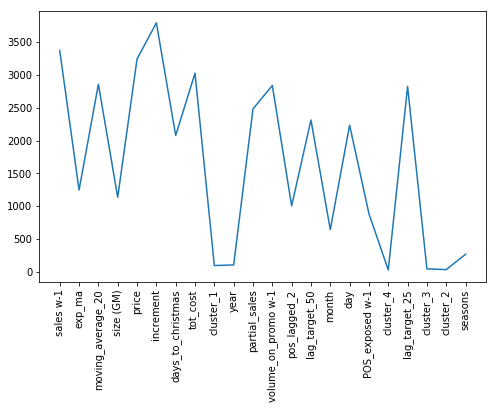

In [313]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.xticks(rotation=90)
plt.plot(feat_imp.keys(), feat_imp.values())
plt.show()